In [113]:
from github import Github, UnknownObjectException, GithubException
import logging

logging.getLogger('matplotlib.font_manager').disabled = True

with open('config.txt', 'r') as config_file:
    auth = config_file.readline().strip('\n')


In [34]:
# First create a Github instance:
g = Github(login_or_token=auth)



In [35]:
# get the organization of interest
org = g.get_organization('bcgov')

In [ ]:
files_dict = {
    'repo': [],
    'readme': [],
    'contributing': [],
    'license': [],
    'code_of_conduct': []
}

n_tot = org.get_repos().totalCount

for ii, repo in enumerate(org.get_repos()):
    # check for existence of required files
    # readme
    try:
        repo.get_contents('README.md')
        readme = 1
    except (UnknownObjectException, GithubException):
        readme = 0
    
    # license
    try:
        repo.get_contents('LICENSE')
        license = 1
    except (UnknownObjectException, GithubException):
        license = 0
        
    # contributing 
    try:
        repo.get_contents('CONTRIBUTING.md')
        contributing = 1
    except (UnknownObjectException, GithubException):
        contributing = 0
        
    try:
        repo.get_contents('CODE_OF_CONDUCT.md')
        coc = 1
    except (UnknownObjectException, GithubException):
        coc = 0
        
    files_dict['repo'].append(repo.name)
    files_dict['readme'].append(readme)
    files_dict['license'].append(license)
    files_dict['contributing'].append(contributing)
    files_dict['code_of_conduct'].append(coc)
    
    print(f'{ii+1:04}/{n_tot}', end='\r')

In [63]:
# re run from later when run out of requests per hour
for ii, repo in enumerate(org.get_repos()):
    # check for existence of required files
    # readme
    if ii>1452:
        try:
            repo.get_contents('README.md')
            readme = 1
        except (UnknownObjectException, GithubException):
            readme = 0

        # license
        try:
            repo.get_contents('LICENSE')
            license = 1
        except (UnknownObjectException, GithubException):
            license = 0

        # contributing 
        try:
            repo.get_contents('CONTRIBUTING.md')
            contributing = 1
        except (UnknownObjectException, GithubException):
            contributing = 0

        try:
            repo.get_contents('CODE_OF_CONDUCT.md')
            coc = 1
        except (UnknownObjectException, GithubException):
            coc = 0

        files_dict['repo'].append(repo.name)
        files_dict['readme'].append(readme)
        files_dict['license'].append(license)
        files_dict['contributing'].append(contributing)
        files_dict['code_of_conduct'].append(coc)

        print(f'{ii+1:04}/{n_tot}', end='\r')

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
df = pd.DataFrame(files_dict)
df['all_required'] = df.readme * df.contributing * df.license
df = df.drop_duplicates(ignore_index=True)

In [138]:
out = df.agg(
    {
        'repo':'count',
        'readme': 'sum',
        'contributing': 'sum',
        'license': 'sum',
        'all_required': 'sum',
        'code_of_conduct': 'sum'
    }
)

count = out.repo

out.index = ['repo', 'README', 'CONTRIBUTING', 'LICENSE', 'ALL REQUIRED', 'CODE OF CONDUCT']
out = pd.DataFrame(out).reset_index()
out.columns = ['name', 'count']

out['pct'] = out['count']/count
out['end_pct'] = 1-out['pct']
out['end_count'] = count - out['count']
out['pct_words'] = out['pct'].apply(lambda x: f'{x:0.1%}')

out = out.sort_values(by='pct', ascending=True)
out = out[out['name'] != 'repo']
out

,name,count,pct,end_pct,end_count,pct_words
5,CODE OF CONDUCT,492,0.256250,0.743750,1428,25.6%
4,ALL REQUIRED,567,0.295312,0.704688,1353,29.5%
2,CONTRIBUTING,629,0.327604,0.672396,1291,32.8%
3,LICENSE,1605,0.835938,0.164062,315,83.6%
1,README,1765,0.919271,0.080729,155,91.9%


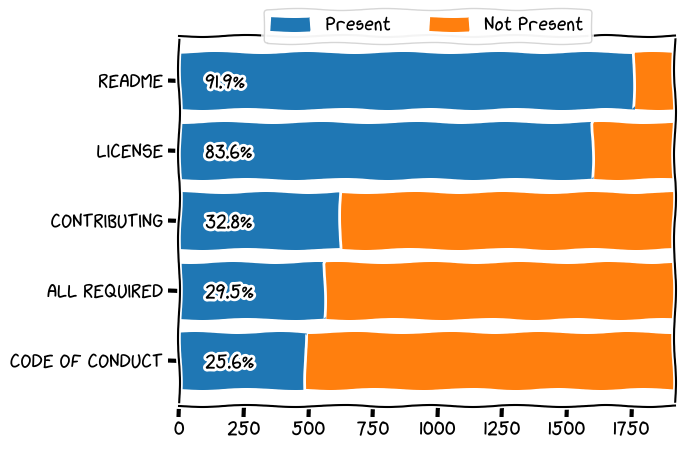

In [137]:
with plt.xkcd():
    plt.barh(
        y = out['name'],
        width = out['count'],
        label = 'Present'
    )
    plt.barh(
        y = out['name'],
        width = out['end_count'],
        left = out['count'],
        label = 'Not Present'
    )
    
    for ii in range(0,5):
        plt.text(
            x = 100,
            y = ii-0.1,
            s = out['pct_words'].values[ii]
        )
    
    plt.xlim([0,1920])
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor = (0.5, 1.1))
    
    plt.savefig('figures/required_files.png', bbox_inches='tight')
    plt.show()